In [1]:
import numpy as np
from solver import freq_top_opt_2D
import matplotlib.pyplot as plt
%matplotlib inline
verbose = False
if not verbose:
    import warnings
    warnings.filterwarnings("ignore")

In [2]:
res  =  0.05 # inverse of resolution
scaling = res*1e-6 # the scale applied to the physical problem
nElx =  int(14/res) # the number of elements in the X axis
nEly=  int(4/res) # the number of elements in the Y axis
nodesX = nElx + 1
nodesY = nEly + 1
print("scaling", scaling)

nodesX_EM = nodesX
nodesY_EM = nodesY
nodesX_heat = nodesX
nodesY_heat = nodesY

scaling 5e-08


In [3]:
n_metal = 3.1477 # refractive index for TiN
k_r =  5.8429  # exctinction coefficient for TiN
n_wg  = np.sqrt(15.054) # refractive index of the waveguide
n_clad = np.sqrt(4.2) # refractive index of cladding
dz = 200E-6 / 4
h_core = 1e-6 / scaling
w_core = 10e-6 / scaling  #10e-6 / scaling 

In [4]:
wl = 1.55 / res #1.55 / res  # value for the wavelentgth, i.e. 1.55 um.
k = 2 * np.pi / (wl * scaling) # value of the wavevector
delta = 3.8193 #3.8191 #3.81969697 #3.82015075 #3.8204 #3.82104208  #3.818  # Effective refractive index from COMSOL
deltaT = 3.8208 #3.819545 #3.8205 #3.820100 #3.85787879#3.82155779#3.82111111 #3.82155779 #3.82155779 # previous: 3.8624
print("Initial effective index: ", delta)
print("Heated effective index: ", deltaT)

Initial effective index:  3.8193
Heated effective index:  3.8208


In [5]:
fR = 4 # value for the filtering radius   
maxItr = 100  # number of iterations performed by the optimizer
alg = "MMA" # algorithm: Method of  Moving Asymptotes
eta = 0.5 # parameter that controls threshold value.
beta = 1E9 #2.25 * 5 #2.25 * 5 #1E9 # parameter that controls threshold sharpness.
alpha = 0 #2.25
FOM_type = "linear"
tol = 1e-8

In [6]:
dVini_Omega_1 = 0.0 # intial value of design parameters in Omega_1
dVini_Omega_3 = 0.0 # intial value of design parameters in Omega_3
nEl_Omega_3 = 0

In [7]:
nEly_heat = nEly
nElx_heat = nElx
nEly_EM = nEly
nElx_EM = nElx


volume1  = np.zeros((nEly_heat, nElx_heat))
volume2  = np.zeros((nEly_heat, nElx_heat))
volume4  = np.zeros((nEly_heat, nElx_heat))
volume5  = np.zeros((nEly_heat, nElx_heat))


volume3 = np.zeros((nEly_heat+1, nElx_heat+1))

h_domain = 4E-6 / scaling#10e-6
alpha = 0.0

w_non_design = w_core + alpha * (h_domain-h_core)
h_non_design = h_core + alpha * (h_domain-h_core)

w_design_limit = nElx_EM 
h_design_limit = nEly_EM


volume1 [nEly_heat//2 - int(0.5*h_core) : nEly_heat//2 + int(0.5*h_core),nElx_heat//2 - int(0.5*w_core) : nElx_heat//2 + int(0.5*w_core)] = 1 # waveguide region
volume4 [nEly_heat//2 - int(0.5*h_non_design) : nEly_heat//2 + int(0.5*h_non_design),nElx_heat//2 - int(0.5*w_non_design) : nElx_heat//2 + int(0.5*w_non_design)] = 1
volume5 [nEly_heat//2 - h_design_limit//2 :nEly_heat//2 + h_design_limit//2 ,nElx_heat//2 - w_design_limit//2 : nElx_heat//2 + w_design_limit//2] = 1 
volume5 = volume5 - volume4

print(np.shape(volume4 [nEly_heat//2 - int(0.5*h_non_design) : nEly_heat//2 + int(0.5*h_non_design),nElx_heat//2 - int(0.5*w_non_design) : nElx_heat//2 + int(0.5*w_non_design)]))
print(np.shape(volume5 [nEly_heat//2 - h_design_limit//2 :nEly_heat//2 + h_design_limit//2 ,nElx_heat//2 - w_design_limit//2 : nElx_heat//2 + w_design_limit//2]))


indexes_design_limit = np.array(np.where(volume5<1))
volume4 [indexes_design_limit[0,:], indexes_design_limit[1,:]] = 1

volume3 [(nEly_heat+1)//2 - int(0.5*h_core) : (nEly_heat+1)//2 + int(0.5*h_core),(nElx_heat+1)//2 - int(0.5*w_core) : (nElx_heat+1)//2 + int(0.5*w_core)] = 1 # waveguide region
indexes_heating = np.array(np.where(volume3 > 0.5))
indexes_design_region_heat = np.array(np.where(volume5 == 1))
indexes_RHS = np.array(np.where(volume3 < 1))

indexes_wg_heat = np.array(np.where(volume3 == 1))


volume2 [nEly_heat//2 - int(0.5*h_core)-nEl_Omega_3:nEly_heat//2 + int(0.5*h_core)+nEl_Omega_3,nElx_heat//2 - int(0.5*w_core)-nEl_Omega_3:nElx_heat//2 + int(0.5*w_core)+nEl_Omega_3] = 1 # non-constraint region
volume3 = volume2 - volume1
indexes_heating_heat = np.array(np.where(volume3 > 0.5))
from wg_index import calc_index_constraint
indexes_constraint = (calc_index_constraint(indexes_design_region_heat, indexes_heating_heat)).astype(int)

dVini = dVini_Omega_1 *  np.ones_like(np.array(indexes_design_region_heat[0,:]).flatten()) 
dVini [indexes_constraint]= dVini_Omega_3

h_metal = 0.25E-6 / scaling
w_metal = 4E-6 / scaling
volume4 [:, :] = 0.0
volume4 [nEly//2 + int(0.5*h_core) : nEly//2 + int(0.5*h_core) + int(h_metal) , nElx//2 - int(0.5*w_core) : nElx//2 - int(0.5*w_core) + int(w_metal)] = 1 # metal region
indexes_metal = np.array(np.where(volume4 > 0.5))

from wg_index import calc_index_constraint

indexes_constraint = (calc_index_constraint(indexes_design_region_heat, indexes_heating)).astype(int)
indexes_metal_heater = (calc_index_constraint(indexes_design_region_heat, indexes_metal)).astype(int)
dVini = dVini_Omega_1 *  np.ones_like(np.array(indexes_design_region_heat[0,:]).flatten()) 
#dVini[:] = 0.5
dVini [indexes_metal_heater]= 1.0
volume1_heat = volume1


random = False
if random:
    dVini = np.random.rand(len(dVini))

(20, 200)
(80, 280)


In [8]:
indexes_design_region_EM = indexes_design_region_heat
indexes_wg_EM = indexes_wg_heat
indexes_heating_EM = indexes_heating_heat

In [9]:
vol_cons_val = 0.25
heat_cons_val =  0.0

In [10]:
RHS_heater = indexes_wg_heat
val_heater = 20e-3 * np.ones_like(indexes_design_region_heat)
dz = 200e-6
k_wg = 148 
k_clad = 1.38 
k_metal = 28

In [11]:
print('Lenght of simulation domain in X: ', nElx_EM*scaling)
print('Lenght of simulation domain in Y: ', nEly_EM*scaling)
print('Wavelength of the problem: ', wl*scaling)
print('Dielectric constant (real part) of metal: ', n_metal**2)

Lenght of simulation domain in X:  1.4e-05
Lenght of simulation domain in Y:  4e-06
Wavelength of the problem:  1.55e-06
Dielectric constant (real part) of metal:  9.90801529


In [12]:
L = dz

phase_shift = (deltaT-delta)*(2*np.pi*L)/(wl*scaling)
print("Phase-shift: ", str(phase_shift)+"  rad")

Phase-shift:  1.2161003820348046  rad


In [13]:
solver = freq_top_opt_2D( nElx_EM, 
                          nEly_EM,
                          nElx_heat, 
                          nEly_heat,
                          dVini,
                          w_core,
                          h_core,
                          n_metal,
                          k_r,
                          n_wg,
                          n_clad,
                          wl,
                          delta,
                          deltaT,  
                          fR,
                          eta,
                          beta,
                          scaling,
                          vol_cons_val,
                          FOM_type,
                          indexes_wg_EM,
                          indexes_wg_heat,
                          indexes_design_region_EM,
                          indexes_design_region_heat,
                          heat_cons_val,
                          indexes_heating_EM,
                          indexes_heating_heat,
                          continuation_scheme= False,
                          heating_constraint= False,
                          volume_constraint= False,
                          eliminate_excitation= False,
                          dz=dz,
                          alpha=alpha,
                          k_wg = k_wg,
                          k_clad = k_clad,
                          k_metal = k_metal,
                          debug=False,
                          logfile=False
                        )

EDGE NUMBERING: (MAX, MIN): 
45159.0
0.0


In [14]:
dVs = dVini
dVs = np.load("dVs_length.npy")
#_ = solver.solve_heat(dVs, solver, idx_RHS = indexes_design_region_heat, val_RHS=val_heater)

---------------------------------------------------
Solving for the unheated device ...
---------------------------------------------------


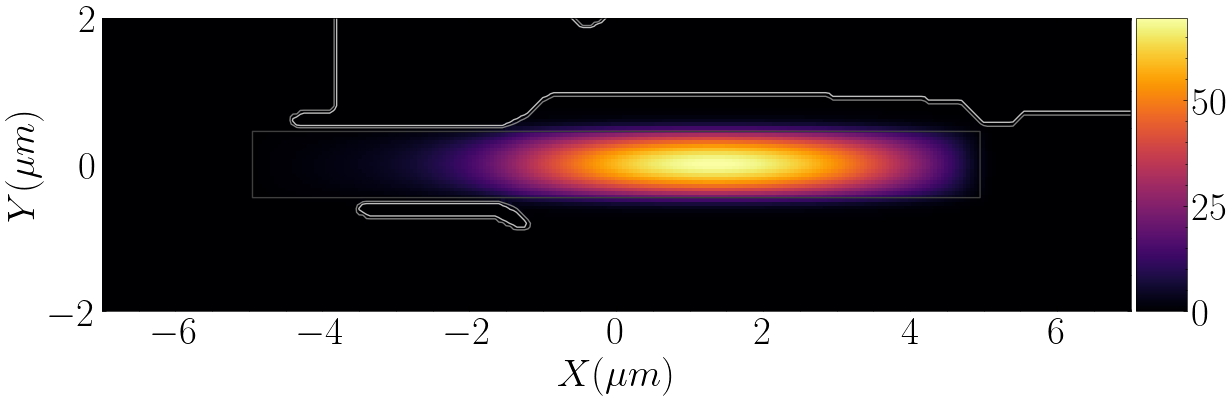

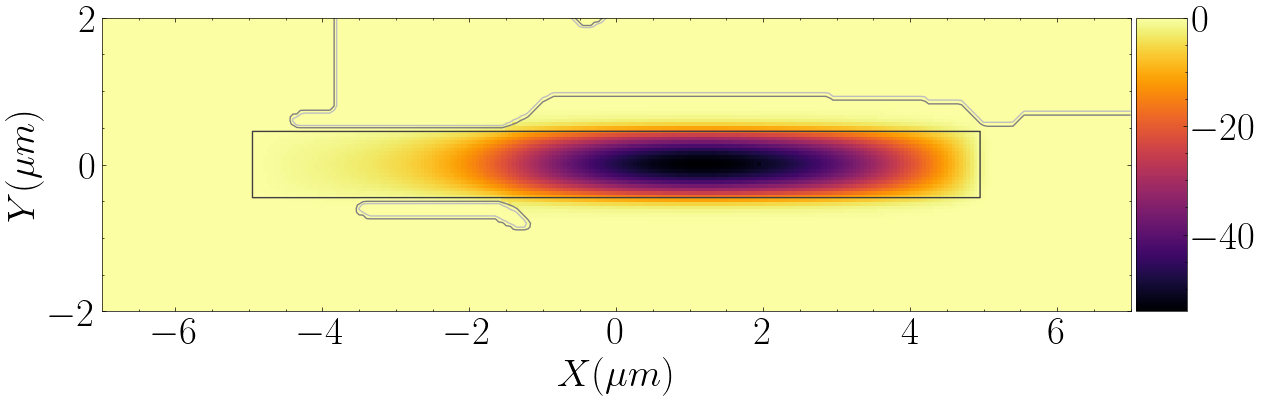

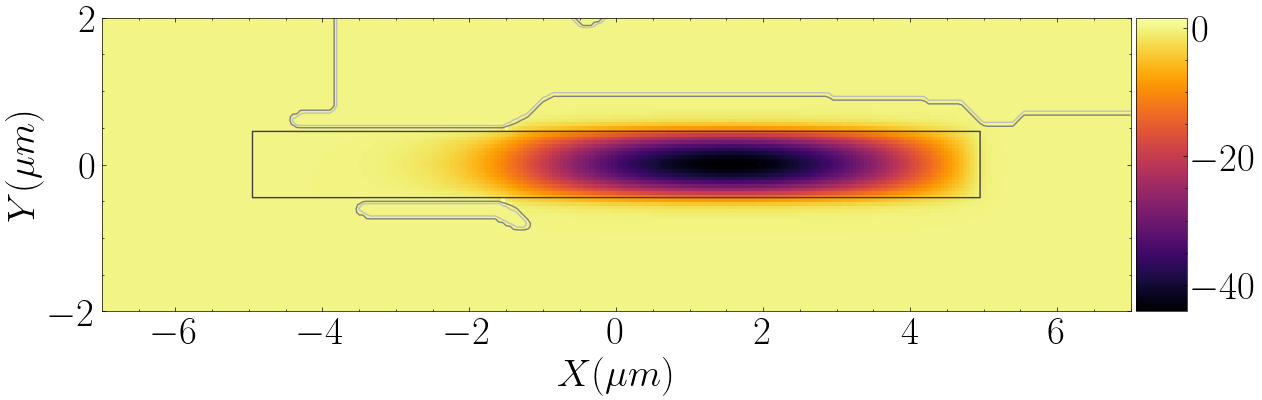

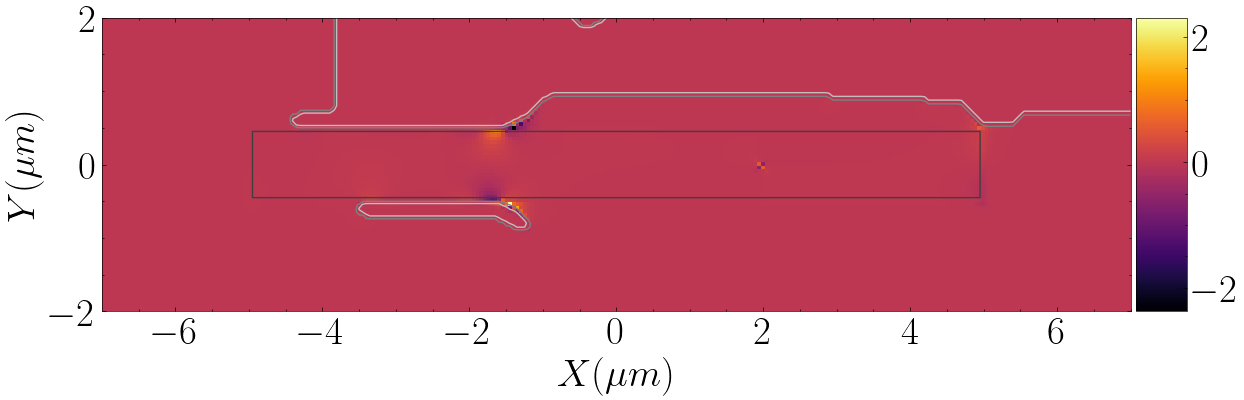

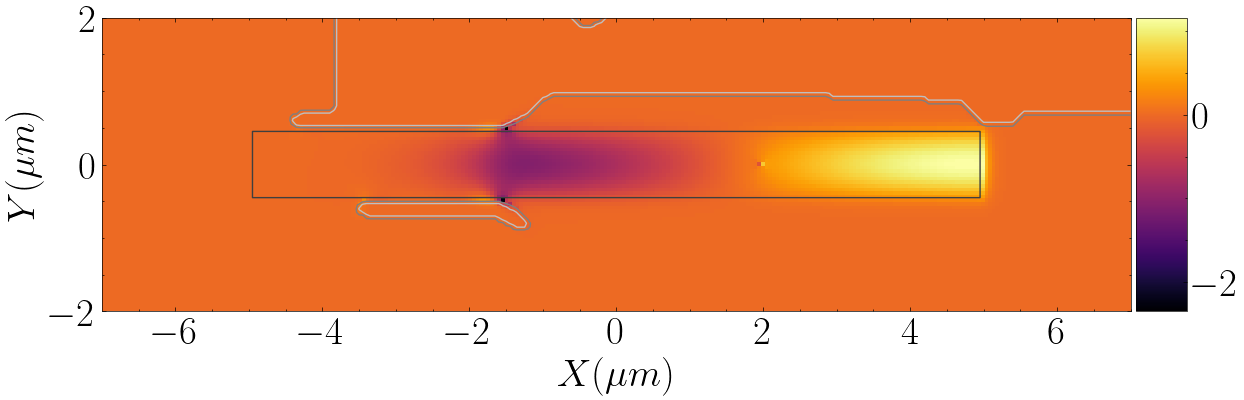

EM FOM, for unheated device:  None
---------------------------------------------------
Solving for the heat propagation...
---------------------------------------------------


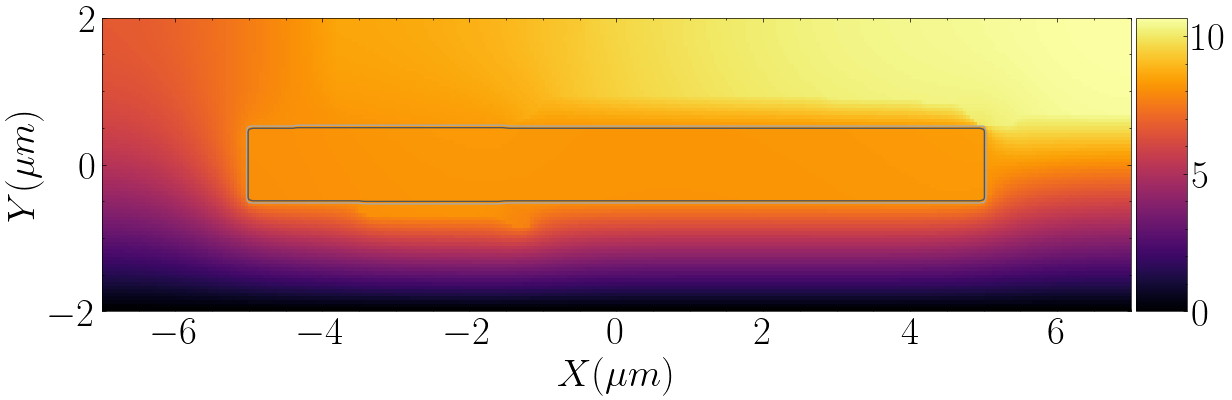

---------------------------------------------------
Solving for the heated device ...
---------------------------------------------------


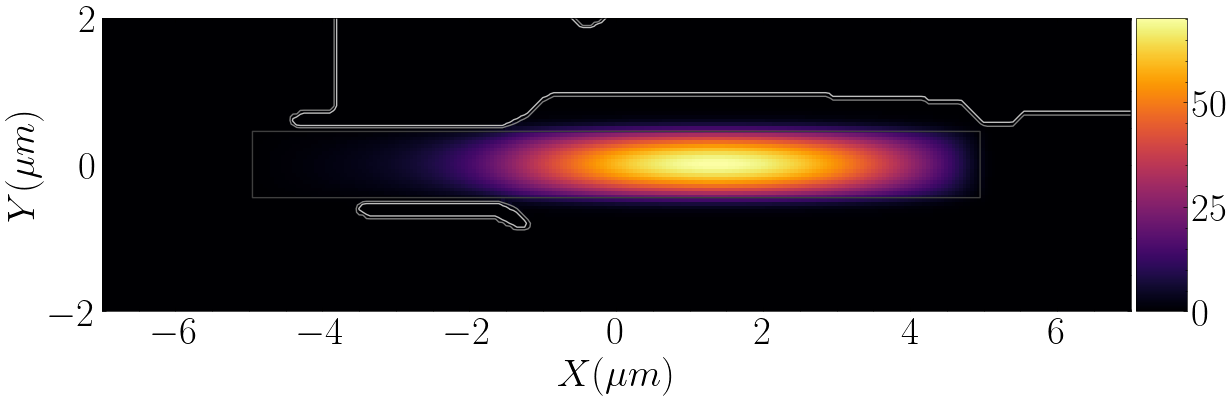

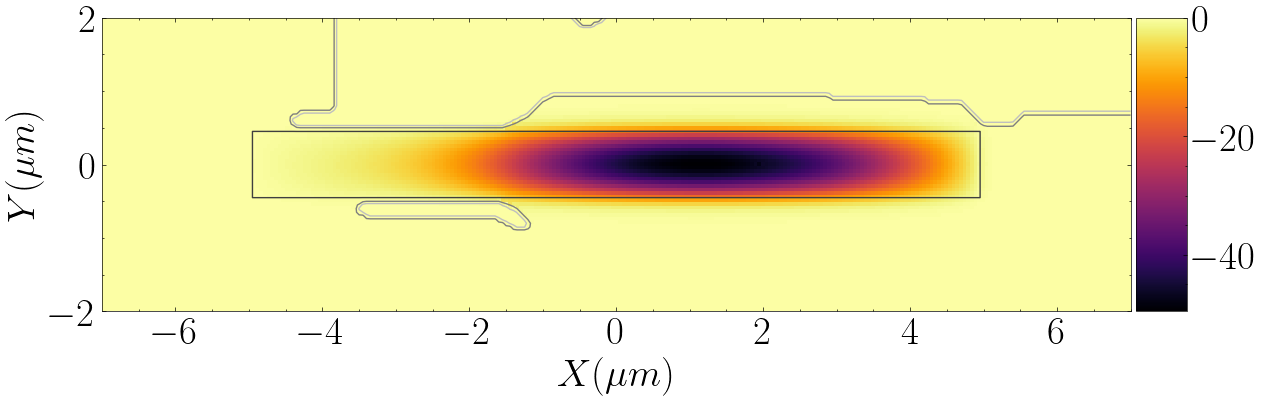

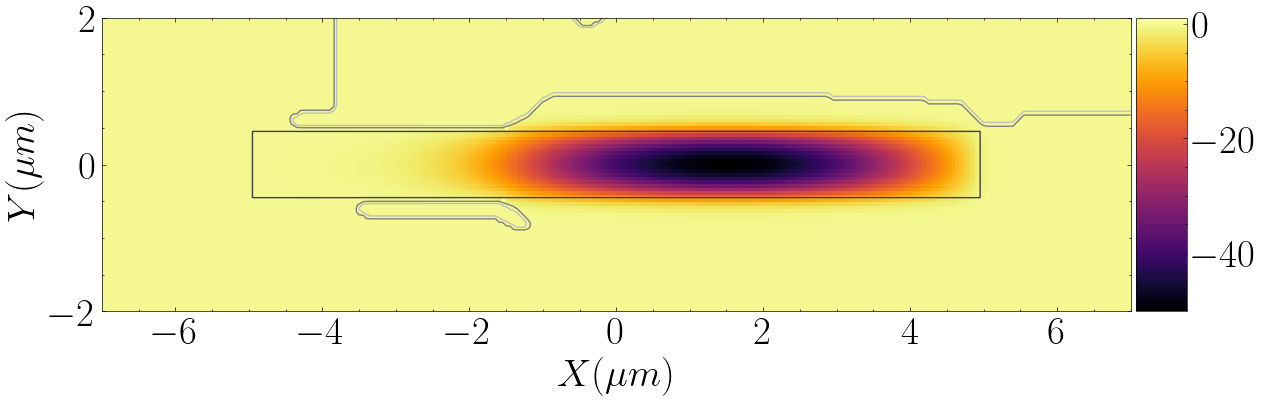

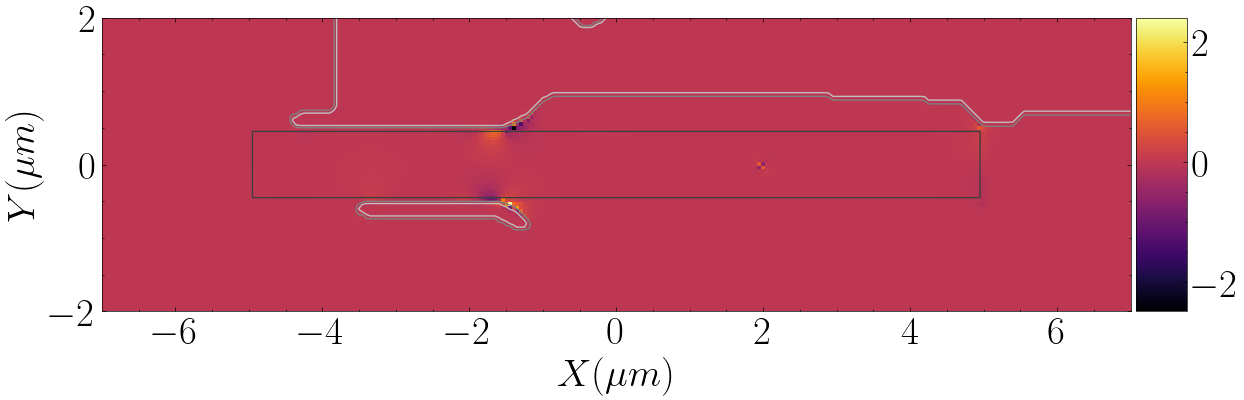

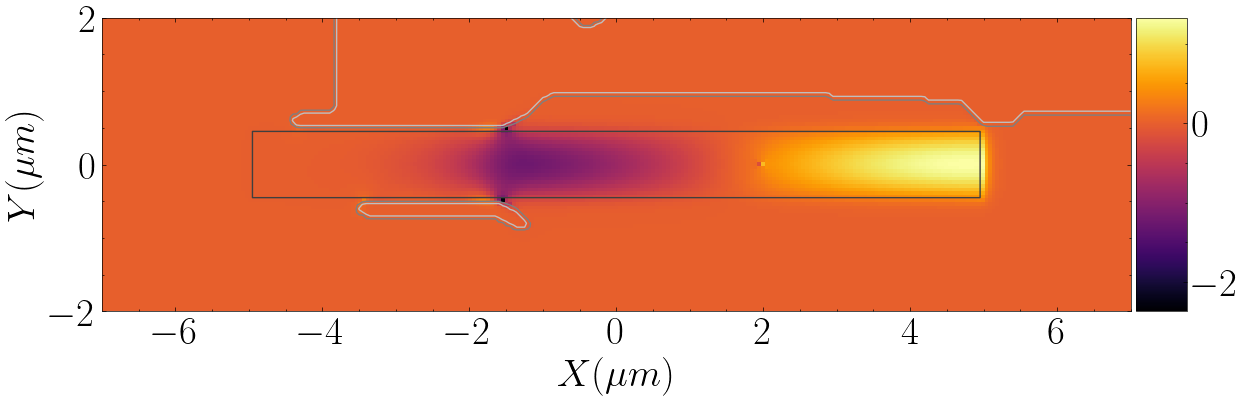

EM FOM, for heated device:  None


In [15]:
N_edges =  nElx * (nEly+1) +  nEly * (nElx+1)
num_nodes_Q8 = (2 * nElx +1) * (nEly + 1) + (nElx+1) * nEly


node_RHS =   int(0.5*N_edges+0.1428*nElx) #int(0.5*N_edges+0.1428*nElx) #int(N_edges + 0.5*num_nodes_Q8 + 0.5 * 0.325*(2 * nElx +1))
idx_RHS_EM = np.array([node_RHS]).astype(int) #np.array([node_RHS]).astype(int) #np.array([node_RHS, node_RHS-0.5*nodesX+1]).astype(int)
val_RHS_EM = np.array([1-1j]) # np.array([0.5E-5*(1+0.5E-4j)]) * 10 #np.array([0.5E-5*(1+0.5E-4j), -0.5E-5*(1+0.5E-4j)]) * 10

solver.solve_coupled(dVs, solver='RHS', idx_RHS_EM = idx_RHS_EM, val_RHS_EM = val_RHS_EM, idx_RHS_heat=indexes_design_region_heat, val_RHS_heat=val_heater)

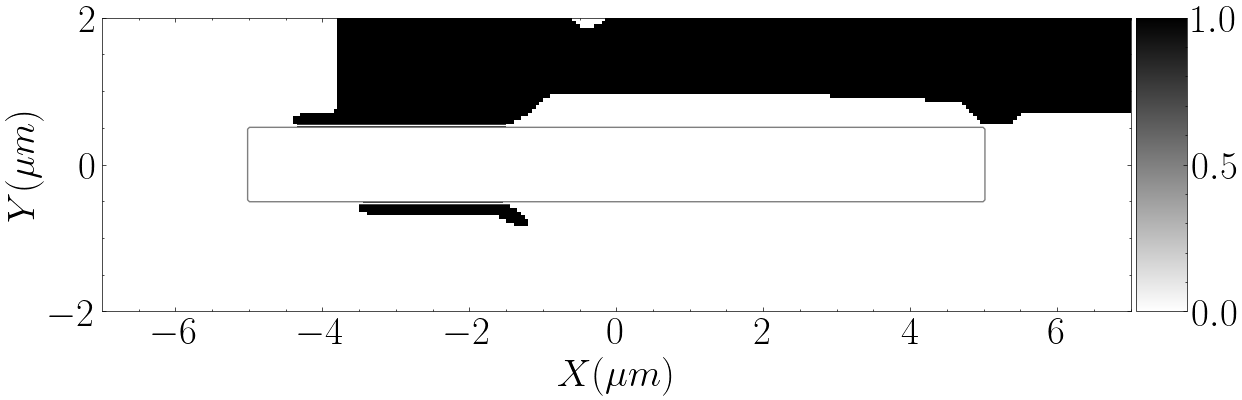

In [16]:
solver.plot_material_interpolation()

In [17]:
raise()

TypeError: exceptions must derive from BaseException

In [ ]:
# IF PYTHON FOR LENGTHSCALE
real_design_variables = solver.dis_heat.dFPST.T
np.save("optimized.npy",real_design_variables)

In [ ]:
real_design_variables = solver.dis_heat.dFPST.T
import scipy.io
mdic = {"matrix": real_design_variables, "label": "optimized"}
scipy.io.savemat('optimized.mat', mdic)

In [ ]:
real_waveguide = solver.dis_heat.dFPST.T
real_waveguide [:,:] = 0.0
real_waveguide [indexes_design_region_EM[1,:], indexes_design_region_EM[0,:]] = 1.0
mdic = {"matrix": real_waveguide, "label": "optimized"}
scipy.io.savemat('optimized.mat', mdic)

In [ ]:
print(np.shape(real_design_variables))